<a href="https://colab.research.google.com/github/sureshmecad/Google-Colab/blob/master/2_KFold_cross_validation_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- https://www.youtube.com/watch?v=ZnSJgIULMVY ---> K-Fold, Stratified, Leave One Out, Repeated K-Fold Cross Validation

- https://www.youtube.com/watch?v=fKz-SgScM3Q ---> Train Test Split vs K Fold vs Stratified K fold Cross Validation ---> Krish Naik

-------------------

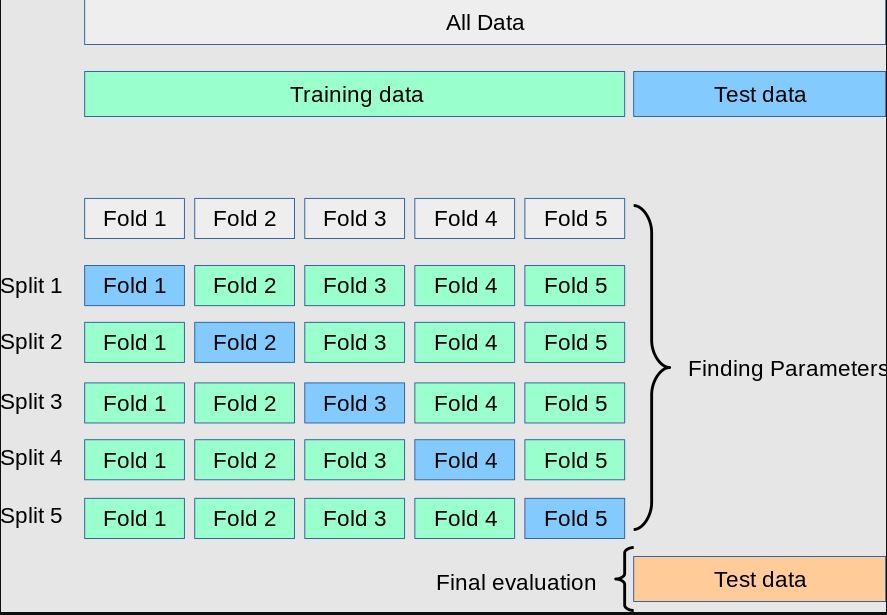

-------------------------

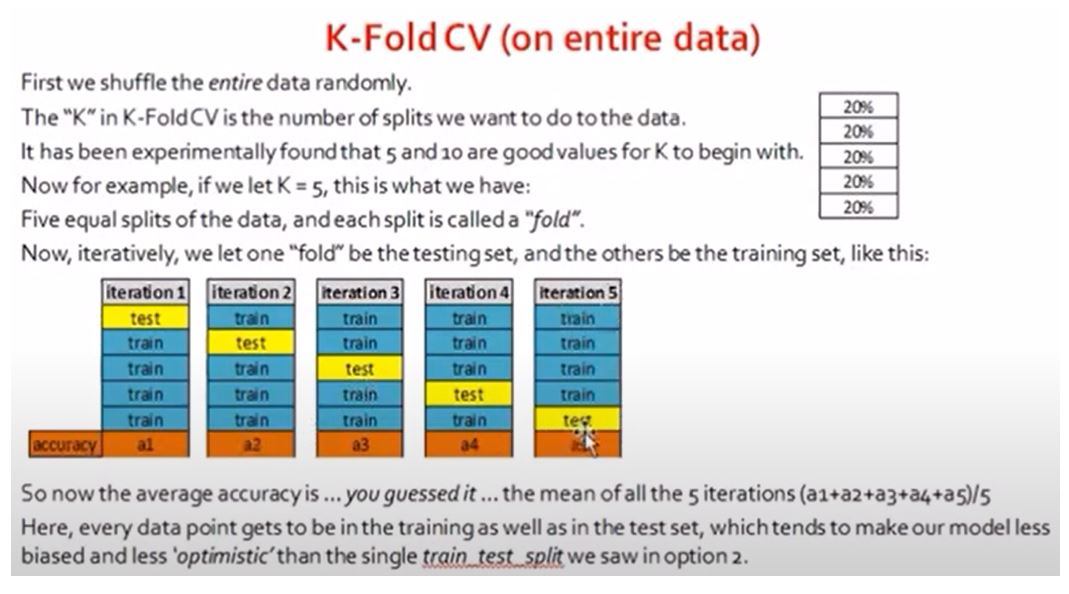

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

import time
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, LeaveOneOut,RepeatedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/Telco-Customer-Churn.zip")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.shape

(7043, 21)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [ ]:
df['Churn_label'] = pd.factorize(df['Churn'])[0]

In [ ]:
df.drop(['customerID', 'Churn'], axis=1, inplace=True)

In [ ]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn_label
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [ ]:
X = df.drop('Churn_label', axis=1)
y = df['Churn_label']

### **KFold**

##### **Method 1**

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=5)

In [ ]:
7043/5  # each fold have 1409

1408.6

In [ ]:
1408.6*4

5634.4

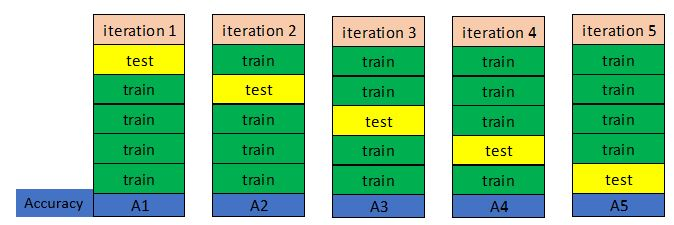

In [ ]:
i=1
for train_set, test_set in kf.split(X=X):
  print("iteration: ", i)
  print(train_set, " having :", len(train_set))
  print(test_set, " having :", len(test_set))
  print("\n")
  i+=1

iteration:  1
[1409 1410 1411 ... 7040 7041 7042]  having : 5634
[   0    1    2 ... 1406 1407 1408]  having : 1409


iteration:  2
[   0    1    2 ... 7040 7041 7042]  having : 5634
[1409 1410 1411 ... 2815 2816 2817]  having : 1409


iteration:  3
[   0    1    2 ... 7040 7041 7042]  having : 5634
[2818 2819 2820 ... 4224 4225 4226]  having : 1409


iteration:  4
[   0    1    2 ... 7040 7041 7042]  having : 5635
[4227 4228 4229 ... 5632 5633 5634]  having : 1408


iteration:  5
[   0    1    2 ... 5632 5633 5634]  having : 5635
[5635 5636 5637 ... 7040 7041 7042]  having : 1408




In [ ]:
num_cols = X.select_dtypes(include=np.number).columns
num_cols

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges'], dtype='object')

In [ ]:
cat_cols = X.select_dtypes(exclude=np.number).columns
cat_cols

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'TotalCharges'],
      dtype='object')

In [ ]:
ct = ColumnTransformer([
    ('rob', RobustScaler(), num_cols),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_cols)
])

In [ ]:
pipe = Pipeline([
    ('ct_step', ct),
    ('model', RandomForestClassifier(n_estimators=10, random_state=0))
])

In [ ]:
scores = []
i = 1
for train_set, test_set in kf.split(X):
    pipe.fit(X.loc[train_set], y[train_set])
    sco = pipe.score(X.loc[test_set], y[test_set])
    scores.append(sco)
    print("iteration ", i)
    i += 1

iteration  1
iteration  2
iteration  3
iteration  4
iteration  5


In [ ]:
np.array(scores)

array([0.77785664, 0.77856636, 0.76437189, 0.77414773, 0.77627841])

In [ ]:
np.array(scores).mean()

0.7742442052713079

In [ ]:
np.array(scores).std()

0.005164116053549352

##### **Method 2**

In [ ]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(pipe, X, y, cv=10)
score

array([0.77588652, 0.78297872, 0.78865248, 0.78551136, 0.76704545,
       0.75142045, 0.78267045, 0.75710227, 0.79261364, 0.77556818])

In [ ]:
score.mean()

0.7759449548678272